## Modeling scATAC-seq using sequence features and a custom kNN graph

In this tutorial we demonstrate the applicability of mubind in a case where an arbitrarily complex graph is provided.
The dataset is mouse pancreatic endocrinogenesis multiome [Klein et al 2023]


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import seaborn

In [3]:
cd ~/workspace/theislab/mubind/docs/notebooks/scatac

/mnt/c/Users/IgnacioIbarra/Dropbox/workspace/theislab/mubind/docs/notebooks/scatac


/home/ilibarra/.conda/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/ilibarra/.conda/envs/mubind/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import pandas as pd
import numpy as np
import os
import torch
import itertools
import glob
import pandas as pd
from pathlib import Path
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'
import torch
import mubind as mb
from tqdm.notebook import tqdm_notebook as tqdm

In [5]:
# pwms = mb.datasets.cisbp_hs()
pwms = mb.datasets.archetypes()
# pwms = pwms[:20]
len(pwms)

# motifs loaded 2179


286

In [6]:
import random
# reduced_groups = [p.to_numpy() for p in random.sample(pwms, 20) if p.shape[-1] != 0]

In [7]:

# suppress numba deprecations warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [8]:

import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
# mb.models.Mubind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

# device = 'cpu'

Using device: cuda:0


In [9]:
import scanpy as sc

In [10]:
# load the pancreas multiome dataset
rna, atac = mb.datasets.pancreas_multiome() # data_directory='../../../annotations/scatac')
rna.shape, atac.shape

True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_rna_velocities_2024.h5ad
True data/scatac/pancreas_multiome/pancreas_multiome_2022_processed_atac.h5ad


((16918, 14663), (16918, 228259))

In [11]:
# if rapids is available, use it
# import rapids_singlecell as rapids
# rapids.pp.neighbors(rna)

# if rapids is not avaible, default scanpy
sc.pp.neighbors(rna)


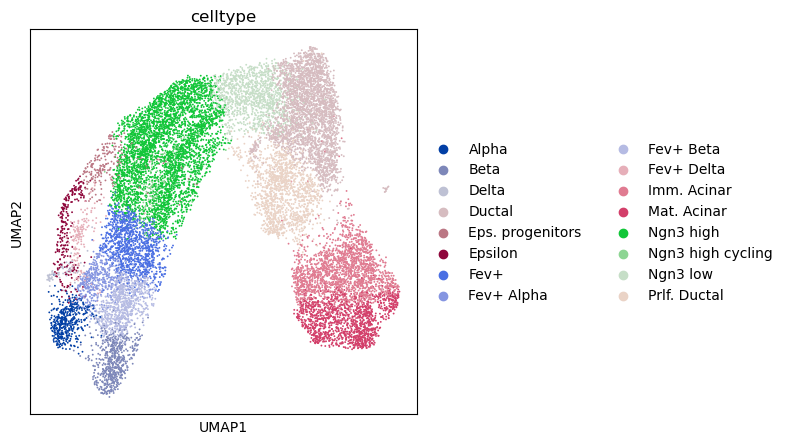

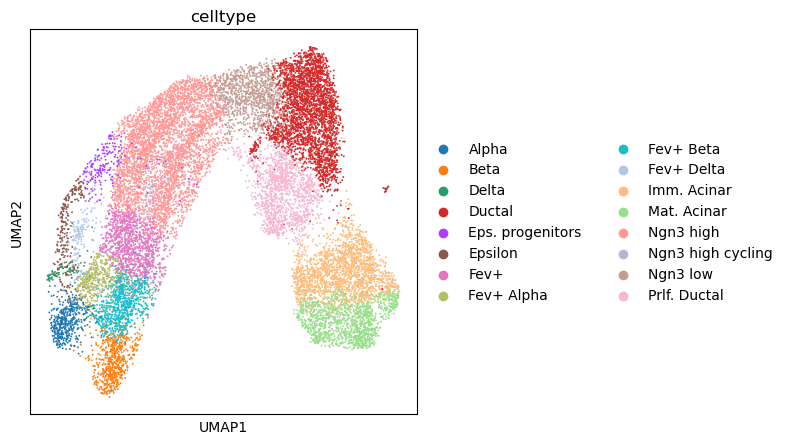

In [12]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 5

# RNA
sc.pl.umap(rna, color='celltype')

#ATAC
sc.pl.umap(atac, color='celltype')

In [13]:
atac.obs_names

Index(['AAACAGCCAACAGCCT-1-0', 'AAACAGCCAACCCTCC-1-0', 'AAACAGCCACCTGTAA-1-0',
       'AAACAGCCACTAAGCC-1-0', 'AAACAGCCAGGATAAC-1-0', 'AAACAGCCATAAAGCA-1-0',
       'AAACATGCAAGGTAAC-1-0', 'AAACATGCAAGGTGGC-1-0', 'AAACATGCACTAGGTC-1-0',
       'AAACATGCAGCATTAT-1-0',
       ...
       'TTTGTGTTCACGAATC-1-1', 'TTTGTGTTCGAGCTAT-1-1', 'TTTGTGTTCGATCAGT-1-1',
       'TTTGTGTTCGCTATGG-1-1', 'TTTGTGTTCTCAATGA-1-1', 'TTTGTGTTCTTGTTCG-1-1',
       'TTTGTTGGTATTGAGT-1-1', 'TTTGTTGGTCCTAAGA-1-1', 'TTTGTTGGTTAACAGT-1-1',
       'TTTGTTGGTTGTTGCT-1-1'],
      dtype='object', length=16918)

In [14]:
# to match the barcode IDs, use the prefix from RNA to match ATAC (anchor = 10 first nucleotides)
assert np.all(rna.obs_names.str[:10] == atac.obs_names.str[:10])
rna.obs_names = atac.obs_names
rna.obs_names

Index(['AAACAGCCAACAGCCT-1-0', 'AAACAGCCAACCCTCC-1-0', 'AAACAGCCACCTGTAA-1-0',
       'AAACAGCCACTAAGCC-1-0', 'AAACAGCCAGGATAAC-1-0', 'AAACAGCCATAAAGCA-1-0',
       'AAACATGCAAGGTAAC-1-0', 'AAACATGCAAGGTGGC-1-0', 'AAACATGCACTAGGTC-1-0',
       'AAACATGCAGCATTAT-1-0',
       ...
       'TTTGTGTTCACGAATC-1-1', 'TTTGTGTTCGAGCTAT-1-1', 'TTTGTGTTCGATCAGT-1-1',
       'TTTGTGTTCGCTATGG-1-1', 'TTTGTGTTCTCAATGA-1-1', 'TTTGTGTTCTTGTTCG-1-1',
       'TTTGTTGGTATTGAGT-1-1', 'TTTGTTGGTCCTAAGA-1-1', 'TTTGTTGGTTAACAGT-1-1',
       'TTTGTTGGTTGTTGCT-1-1'],
      dtype='object', length=16918)

(array([  782.,   732.,   754.,   730.,   746.,   679.,   702.,   737.,
          666.,   657.,   638.,   621.,   587.,   636.,   639.,   640.,
          699.,   756.,   778.,   850.,   944.,  1070.,  1290.,  1566.,
         1888.,  2262.,  2990.,  3753.,  5173.,  6968., 10067., 15120.,
        26728., 62772., 71639.]),
 array([0.        , 0.01427051, 0.02854103, 0.04281154, 0.05708206,
        0.07135257, 0.08562309, 0.0998936 , 0.11416412, 0.12843463,
        0.14270515, 0.15697566, 0.17124618, 0.18551669, 0.19978721,
        0.21405772, 0.22832824, 0.24259875, 0.25686927, 0.27113978,
        0.2854103 , 0.29968081, 0.31395133, 0.32822184, 0.34249236,
        0.35676287, 0.37103339, 0.3853039 , 0.39957442, 0.41384493,
        0.42811545, 0.44238596, 0.45665648, 0.47092699, 0.48519751,
        0.49946802]),
 <BarContainer object of 35 artists>)

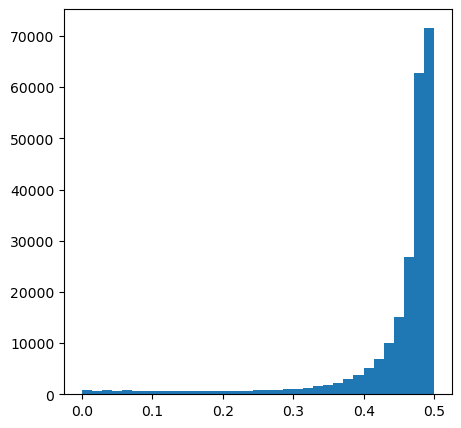

In [15]:
acc = (atac.X != 0).sum(axis=0) / atac.shape[0]
acc_score = abs(.5 - acc)
atac.var['acc_score'] = acc_score.A.T
atac.var['acc_score_rank'] = atac.var['acc_score'].rank(ascending=False)
plt.hist(atac.var['acc_score'], bins=35)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]


In [16]:
n_sample_cells = 200
# n_sample_peaks = 250
n_sample_peaks = int(n_sample_cells * 1.5)

n_cell_types = len(set(atac.obs['celltype']))

obs_sample = atac.obs.groupby('celltype').sample(int(n_sample_cells / n_cell_types), random_state=n_sample_cells).index # pd.Series(atac.obs_names).sample(n_sample_cells)
var_sample = pd.Series(atac.var_names).sample(n_sample_peaks, random_state=n_sample_peaks)
# var_sample = atac.var.sort_values('acc_score_rank').index[:n_sample_peaks]

ad = atac[atac.obs_names.isin(obs_sample),atac.var_names.isin(var_sample)].copy()
ad.shape

(192, 300)

In [17]:
ad.obs['celltype'].value_counts()

celltype
Alpha                12
Beta                 12
Delta                12
Ductal               12
Eps. progenitors     12
Epsilon              12
Fev+                 12
Fev+ Alpha           12
Fev+ Beta            12
Fev+ Delta           12
Imm. Acinar          12
Mat. Acinar          12
Ngn3 high            12
Ngn3 high cycling    12
Ngn3 low             12
Prlf. Ductal         12
Name: count, dtype: int64

In [18]:

# ad.uns['velocity_graph'] = rna_sample.uns['velocity_graph']
# # ad.layers['velocity'] = rna_sample.layers['velocity']
# ad.uns['velocity_graph'].shape



In [19]:

rna_sample = rna[ad.obs_names]

mask = rna.obs_names.isin(rna_sample.obs_names)

# local one step transposition to finalize processing
vgraph = rna.uns['velocity_graph']
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph = vgraph[mask == 1]
vgraph = vgraph.T
vgraph.shape

(192, 192)

In [20]:
# the scvelo package is a condition to explore the vector stream visualization. Not priority
import scvelo as scv

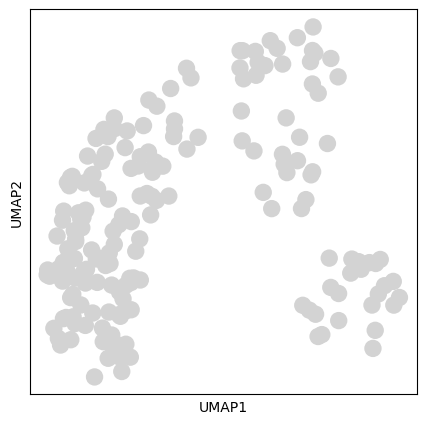

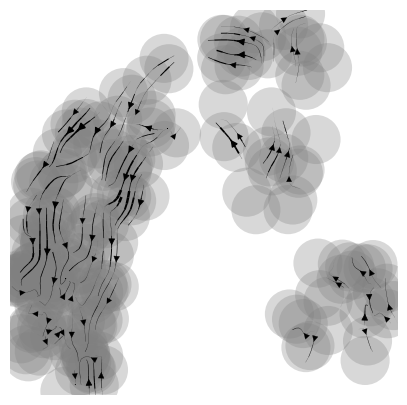

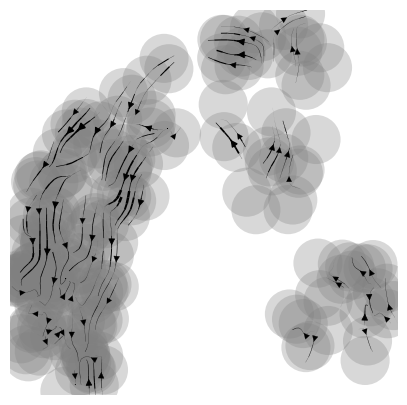

In [21]:

rna_sample.uns['velocity_graph'] = vgraph
try:
# atac
    sc.pl.umap(ad)

    # rna
    # append the estimated velocities to the sample adata
    scv.pl.velocity_embedding_stream(rna_sample)

    scv.pl.velocity_embedding_stream(rna_sample)
    rna_sample.shape
except Exception:
    print('sample too small to plot graph')


In [22]:
ad.var['chr'] = 'chr' + ad.var_names.str.split('-').str[0]
ad.var['start'] = ad.var_names.str.split('-').str[1].astype(int)
ad.var['end'] = ad.var_names.str.split('-').str[2].astype(int)

print('features by chromosome')
extend = 50
ad.var['chr'].value_counts()

features by chromosome


chr
chr4     24
chr6     23
chr2     22
chr5     21
chr11    18
chr9     18
chr3     16
chr1     16
chr13    16
chr17    15
chr19    14
chr10    13
chr14    13
chr7     12
chr12    12
chr8     11
chr18    11
chr16    10
chrX      8
chr15     7
Name: count, dtype: int64

In [23]:
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'] + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)

In [24]:
n_seqs = 10000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='mm10', uppercase=True,
                                            gen_path='../../../annotations/mm10/genome/mm10.fa',
                                            bin='/home/ilibarra/.local/bin/bedtools')
                                            # bin='/home/ilibarra/.conda/envs/mubind/bin/bedtools')
                                            # gen_path='../../../annotations/hg38/genome/hg38.fa')

keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]
len(seqs)

/tmp/tmpdwqv0acp
genome mm10 True
../../../annotations/mm10/genome/mm10.fa
True ../../../annotations/mm10/genome/mm10.fa
running bedtools...
['/home/ilibarra/.local/bin/bedtools', 'getfasta', '-fi', '../../../annotations/mm10/genome/mm10.fa', '-bed', '/tmp/tmpdwqv0acp', '-fo', '/tmp/tmplgkwcd87']
/home/ilibarra/.local/bin/bedtools getfasta -fi ../../../annotations/mm10/genome/mm10.fa -bed /tmp/tmpdwqv0acp -fo /tmp/tmplgkwcd87


300

In [25]:
len(seqs)

300

In [26]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = ad.X.T

In [27]:
counts.shape

(300, 192)

In [28]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)

In [29]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [30]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
next_data.shape

(300, 193)

In [31]:
next_data = next_data[~next_data.index.str.contains('N')]
next_data.shape

(300, 193)

In [32]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [33]:
n_cells = 10000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [34]:
# next_data.index

In [35]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [36]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [37]:
df = next_data_sel.copy() # sample
# df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
# df.index = df.index.astype(str).str[35:-35]
# df = df[~df.index.duplicated(keep='first')]

zero_counts = df.sum(axis=1) == 0
df = df[~zero_counts] # remove zeroes

df.shape

(285, 192)

In [38]:
ad.shape, df.shape

((192, 300), (285, 192))

In [39]:
ad = ad[:,~zero_counts].copy()


In [40]:
df2 = df.reset_index().melt('seq').set_index('seq')
# add a baseline count
df2[0] = 1.0
cols = ['batch', 1, 0]
df2.columns = cols
df2 = df2[[0, 1, 'batch']] # cols[::-1]]
df2['batch'] = df2['batch'].astype(int)
print(df2.shape)
print(len(set(df2['batch'])))
n_cells = 200
df2 = df2[df2['batch'].isin(range(0, n_cells))]
print(df2['batch'].value_counts())
df2.head()

(54720, 3)
192
batch
176    285
177    285
178    285
179    285
180    285
      ... 
3      285
4      285
5      285
6      285
7      285
Name: count, Length: 192, dtype: int64


,0,1,batch
seq,,,
AGTCGGATTGCTTGGGAATGCAGCCCAAAGCGGGTGGTAAACTCCATCTAAGGCTAAATACCGGCACGAGACCGATAGTCAACAAGTACCTAAGGGAAAG,1.0,5.0,0
GCTCGCACCGCCCAGGCCACGCCCCCGCCGCCCGGGCCACGCCCCCTCGCGCCGAGCGCCGAGCGCCGACGCCGGACCGCGTTGATTTGAATTTGGAGCC,1.0,1.0,0
ACCCGCAGTCCTCCACAGGAATGGCTGGCGACCGAGAACCCCGCCGCGCAGGCGCTCTAACCTAACCAATTGGAGGCGGCATCGCGCGCGGATAGCAGCC,1.0,7.0,0
ACATTCCAGGCCCCCCCTCTTCGCCCCGCCCCCTCGGGCTCCCCGTCCCCGCGCCTCCTCCTGGCCGCCTCCCGCCGGAACCGCGCCGCCCCCCGCGCCC,1.0,3.0,0
CGGCGCGAGTACGGATTGGCAGCCAGGCTTGTGCCCCGCCGCGTCCGCCCTTCTACTTCCCTCTCCTAAGTCGGATCCGCCCCTCTCCGCTGGACGCGTA,1.0,0.0,0


### Simple motif enrichment

In [41]:
use_kmers = False
if use_kmers:
    kmers_by_module = {}
    pwm_by_module = {}
    glossary_kmers_dir = '../../../../../zaugglab/apobec2_data_analysis/src/analyses_2023_new_sample/Glossary Modules'
    for f in os.listdir(glossary_kmers_dir):
        if not f.endswith('.xlsx'):
            continue
        name = f.replace('Glossary_module_', '').replace('.xlsx', '')
        kmers = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='8mers')
        kmers_by_module[name] = kmers[kmers.columns[0]]
        pwm = pd.read_excel(os.path.join(glossary_kmers_dir, f), sheet_name='PWM', index_col=0)
        pwm_by_module[name] = pwm

### Generate pos and neg

In [42]:
# import ushuffle

# fg = df.index
# bg = []

# for i, s in enumerate(fg):
#     # print(i, s)
#     bg.append(ushuffle.shuffle(str.encode(s), 2))



In [43]:
# for a, b in zip(fg, bg):
#     # print(len(a[1]), len(b))
#     assert len(a) == len(b)

In [44]:
frac_acc = (df > 0).sum(axis=0) / df.shape[1]

In [45]:
reduced_groups = pwms

In [46]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)
n_batch = len(set(dataset.batch))
n_kernels = len(pwms)
train = tdata.DataLoader(dataset=dataset, batch_size=512, shuffle=True)


In [47]:
# df_neg = df.copy()
# df_neg.index = bg
# df_neg.index = df_neg.index.astype(str)

# dataset_neg = mb.datasets.SelexDataset(df_neg, n_rounds=df_neg.shape[1], enr_series=False)
# train_neg = tdata.DataLoader(dataset=dataset_neg, batch_size=512, shuffle=True)


### The parameter log_dynamic defines whether a kNN-graph will be used

In [48]:
len(pwms)

286

In [49]:
# for unit tests
# torch.save(train, '../../../tests/_data/pancreas_multiome.pth')
# ad.write('../../../tests/_data/pancreas_multiome.h5ad', compression='lzf')

In [50]:
rna_sample.shape, ad.shape

((192, 14663), (192, 285))

In [51]:
criterion = mb.tl.PoissonLoss()
w = [r.shape[1] for r in pwms]
optimize_log_dynamic = True
model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                        # use_dinuc=True, dinuc_mode='full',
                                        optimize_sym_weight=False,
                                        optimize_exp_barrier=True,
                                        optimize_prob_act=True,
                                        optimize_log_dynamic=optimize_log_dynamic,
                                        use_dinuc=False,
                                        device=device,
                                        p_dropout=0.8,
                                        prepare_knn=optimize_log_dynamic,
                                        velocity_graph=vgraph,
                                        knn_free_weights=False,
                                        adata=None if not optimize_log_dynamic else ad,
                                        dinuc_mode=None)
print('no err')

(192, 192)
setting up log dynamic
no err


In [52]:
# model.graph_module.conn_sparse.shape

setting up log dynamic
True
12
order None
0 out of 288...
break


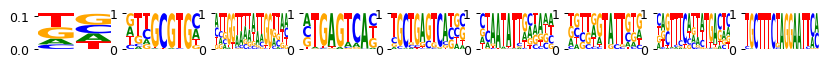

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.08s/it]


Current time: 2024-05-23 16:52:59.251071
	Loss: 268.034 , R2: 0.346
	Training time (model/function): (16.208s / 16.208s)
		per epoch (model/function): (1.158s/ 1.158s)
		per 1k samples: 4.062s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 10

### next filter to optimize 10 

FREEZING KERNELS
optimizing feature type mono
next kernels {10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.34it/s]


Current time: 2024-05-23 16:53:11.013201
	Loss: 258.730 , R2: 0.346
	Training time (model/function): (27.386s / 11.178s)
		per epoch (model/function): (1.956s/ 0.798s)
		per 1k samples: 2.801s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:32<00:00, 14.15s/it]


Current time: 2024-05-23 16:56:44.312112
	Loss: 245.519 , R2: 0.346
	Training time (model/function): (239.706s / 212.320s)
		per epoch (model/function): (17.122s/ 15.166s)
		per 1k samples: 53.213s
best loss 245.519
last five r2 values, by sequential filter optimization: ['0.346']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 20

### next filter to optimize 20 

FREEZING KERNELS
optimizing feature type mono
next kernels {20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:08<00:00,  4.55s/it]


Current time: 2024-05-23 16:57:53.406934
	Loss: 239.680 , R2: 0.346
	Training time (model/function): (307.937s / 68.232s)
		per epoch (model/function): (21.996s/ 4.874s)
		per 1k samples: 17.101s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:40<00:00,  2.69s/it]


Current time: 2024-05-23 16:58:34.342561
	Loss: 226.360 , R2: 0.346
	Training time (model/function): (348.272s / 40.335s)
		per epoch (model/function): (24.877s/ 2.881s)
		per 1k samples: 10.109s
best loss 226.360
last five r2 values, by sequential filter optimization: ['0.346', '0.346']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 30

### next filter to optimize 30 

FREEZING KERNELS
optimizing feature type mono
next kernels {32, 33, 34, 35, 36, 37, 38, 39, 30, 31}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.28it/s]


Current time: 2024-05-23 16:58:48.039452
	Loss: 220.978 , R2: 0.346
	Training time (model/function): (360.008s / 11.735s)
		per epoch (model/function): (25.715s/ 0.838s)
		per 1k samples: 2.941s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:19<00:00,  1.30s/it]


Current time: 2024-05-23 16:59:08.326066
	Loss: 208.618 , R2: 0.347
	Training time (model/function): (379.455s / 19.448s)
		per epoch (model/function): (27.104s/ 1.389s)
		per 1k samples: 4.874s
best loss 208.618
last five r2 values, by sequential filter optimization: ['0.346', '0.346', '0.347']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 40

### next filter to optimize 40 

FREEZING KERNELS
optimizing feature type mono
next kernels {40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.55it/s]


Current time: 2024-05-23 16:59:19.668263
	Loss: 204.526 , R2: 0.347
	Training time (model/function): (389.125s / 9.670s)
		per epoch (model/function): (27.795s/ 0.691s)
		per 1k samples: 2.423s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:40<00:00,  2.73s/it]


Current time: 2024-05-23 17:00:01.524690
	Loss: 193.632 , R2: 0.347
	Training time (model/function): (430.110s / 40.986s)
		per epoch (model/function): (30.722s/ 2.928s)
		per 1k samples: 10.272s
best loss 193.632
last five r2 values, by sequential filter optimization: ['0.346', '0.346', '0.347', '0.347']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:19<00:00,  1.27s/it]


Current time: 2024-05-23 17:00:23.922676
	Loss: 191.058 , R2: 0.348
	Training time (model/function): (449.207s / 19.096s)
		per epoch (model/function): (32.086s/ 1.364s)
		per 1k samples: 4.786s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:13<00:00,  1.09it/s]


Current time: 2024-05-23 17:00:38.052269
	Loss: 181.657 , R2: 0.348
	Training time (model/function): (462.919s / 13.712s)
		per epoch (model/function): (33.066s/ 0.979s)
		per 1k samples: 3.437s
best loss 181.657
last five r2 values, by sequential filter optimization: ['0.346', '0.346', '0.347', '0.347', '0.348']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 60

### next filter to optimize 60 

FREEZING KERNELS
optimizing feature type mono
next kernels {64, 65, 66, 67, 68, 69, 60, 61, 62, 63}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:12<00:00,  1.18it/s]


Current time: 2024-05-23 17:00:51.999238
	Loss: 180.492 , R2: 0.349
	Training time (model/function): (475.634s / 12.715s)
		per epoch (model/function): (33.974s/ 0.908s)
		per 1k samples: 3.187s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:25<00:00,  1.69s/it]


Current time: 2024-05-23 17:01:17.869425
	Loss: 172.392 , R2: 0.349
	Training time (model/function): (501.067s / 25.433s)
		per epoch (model/function): (35.790s/ 1.817s)
		per 1k samples: 6.374s
best loss 172.392
last five r2 values, by sequential filter optimization: ['0.346', '0.347', '0.347', '0.348', '0.349']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 70

### next filter to optimize 70 

FREEZING KERNELS
optimizing feature type mono
next kernels {70, 71, 72, 73, 74, 75, 76, 77, 78, 79}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:20<00:00,  1.39s/it]


Current time: 2024-05-23 17:01:40.202169
	Loss: 172.402 , R2: 0.350
	Training time (model/function): (521.994s / 20.927s)
		per epoch (model/function): (37.285s/ 1.495s)
		per 1k samples: 5.245s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:35<00:00,  2.38s/it]


Current time: 2024-05-23 17:02:22.718513
	Loss: 165.353 , R2: 0.350
	Training time (model/function): (557.685s / 35.692s)
		per epoch (model/function): (39.835s/ 2.549s)
		per 1k samples: 8.945s
best loss 165.353
last five r2 values, by sequential filter optimization: ['0.347', '0.347', '0.348', '0.349', '0.350']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 80

### next filter to optimize 80 

FREEZING KERNELS
optimizing feature type mono
next kernels {80, 81, 82, 83, 84, 85, 86, 87, 88, 89}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:18<00:00,  1.26s/it]


Current time: 2024-05-23 17:05:06.132793
	Loss: 166.291 , R2: 0.351
	Training time (model/function): (576.666s / 18.980s)
		per epoch (model/function): (41.190s/ 1.356s)
		per 1k samples: 4.757s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:45<00:00,  3.05s/it]


Current time: 2024-05-23 17:05:52.811798
	Loss: 160.060 , R2: 0.352
	Training time (model/function): (622.477s / 45.811s)
		per epoch (model/function): (44.463s/ 3.272s)
		per 1k samples: 11.481s
best loss 160.060
last five r2 values, by sequential filter optimization: ['0.347', '0.348', '0.349', '0.350', '0.351']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 90

### next filter to optimize 90 

FREEZING KERNELS
optimizing feature type mono
next kernels {96, 97, 98, 99, 90, 91, 92, 93, 94, 95}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:15<00:00,  1.02s/it]


Current time: 2024-05-23 17:06:11.449333
	Loss: 161.710 , R2: 0.351
	Training time (model/function): (637.789s / 15.312s)
		per epoch (model/function): (45.556s/ 1.094s)
		per 1k samples: 3.838s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:09<00:00,  4.62s/it]


Current time: 2024-05-23 17:07:21.482778
	Loss: 156.102 , R2: 0.349
	Training time (model/function): (707.031s / 69.242s)
		per epoch (model/function): (50.502s/ 4.946s)
		per 1k samples: 17.354s
best loss 156.102
last five r2 values, by sequential filter optimization: ['0.348', '0.349', '0.350', '0.351', '0.349']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {100, 101, 102, 103, 104, 105, 106, 107, 108, 109}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:14<00:00,  1.03it/s]


Current time: 2024-05-23 17:07:37.278679
	Loss: 158.292 , R2: 0.349
	Training time (model/function): (721.597s / 14.566s)
		per epoch (model/function): (51.543s/ 1.040s)
		per 1k samples: 3.651s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.65it/s]


Current time: 2024-05-23 17:07:46.901375
	Loss: 153.153 , R2: 0.348
	Training time (model/function): (730.700s / 9.103s)
		per epoch (model/function): (52.193s/ 0.650s)
		per 1k samples: 2.281s
best loss 153.153
last five r2 values, by sequential filter optimization: ['0.349', '0.350', '0.351', '0.349', '0.349']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 110

### next filter to optimize 110 

FREEZING KERNELS
optimizing feature type mono
next kernels {110, 111, 112, 113, 114, 115, 116, 117, 118, 119}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.80it/s]


Current time: 2024-05-23 17:07:56.218771
	Loss: 155.748 , R2: 0.349
	Training time (model/function): (739.022s / 8.322s)
		per epoch (model/function): (52.787s/ 0.594s)
		per 1k samples: 2.086s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.31it/s]


Current time: 2024-05-23 17:08:08.640920
	Loss: 150.958 , R2: 0.349
	Training time (model/function): (750.450s / 11.427s)
		per epoch (model/function): (53.604s/ 0.816s)
		per 1k samples: 2.864s
best loss 150.958
last five r2 values, by sequential filter optimization: ['0.350', '0.351', '0.349', '0.349', '0.349']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 120

### next filter to optimize 120 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.71it/s]


Current time: 2024-05-23 17:08:18.671279
	Loss: 153.855 , R2: 0.350
	Training time (model/function): (759.224s / 8.775s)
		per epoch (model/function): (54.230s/ 0.627s)
		per 1k samples: 2.199s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.49it/s]


Current time: 2024-05-23 17:08:29.366643
	Loss: 149.327 , R2: 0.349
	Training time (model/function): (769.291s / 10.067s)
		per epoch (model/function): (54.949s/ 0.719s)
		per 1k samples: 2.523s
best loss 149.327
last five r2 values, by sequential filter optimization: ['0.351', '0.349', '0.349', '0.349', '0.350']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 130

### next filter to optimize 130 

FREEZING KERNELS
optimizing feature type mono
next kernels {130, 131, 132, 133, 134, 135, 136, 137, 138, 139}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.28it/s]


Current time: 2024-05-23 17:08:42.459138
	Loss: 152.448 , R2: 0.350
	Training time (model/function): (781.024s / 11.733s)
		per epoch (model/function): (55.787s/ 0.838s)
		per 1k samples: 2.941s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.11s/it]


Current time: 2024-05-23 17:08:59.795416
	Loss: 148.115 , R2: 0.350
	Training time (model/function): (797.614s / 16.590s)
		per epoch (model/function): (56.972s/ 1.185s)
		per 1k samples: 4.158s
best loss 148.115
last five r2 values, by sequential filter optimization: ['0.349', '0.349', '0.349', '0.350', '0.350']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 140

### next filter to optimize 140 

FREEZING KERNELS
optimizing feature type mono
next kernels {140, 141, 142, 143, 144, 145, 146, 147, 148, 149}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.64it/s]


Current time: 2024-05-23 17:09:10.282208
	Loss: 151.402 , R2: 0.350
	Training time (model/function): (806.764s / 9.150s)
		per epoch (model/function): (57.626s/ 0.654s)
		per 1k samples: 2.293s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.48it/s]


Current time: 2024-05-23 17:09:20.988979
	Loss: 147.215 , R2: 0.349
	Training time (model/function): (816.938s / 10.174s)
		per epoch (model/function): (58.353s/ 0.727s)
		per 1k samples: 2.550s
best loss 147.215
last five r2 values, by sequential filter optimization: ['0.349', '0.349', '0.350', '0.350', '0.348']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:15<00:00,  1.01s/it]


Current time: 2024-05-23 17:09:37.292789
	Loss: 150.626 , R2: 0.350
	Training time (model/function): (832.161s / 15.223s)
		per epoch (model/function): (59.440s/ 1.087s)
		per 1k samples: 3.815s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.60s/it]


Current time: 2024-05-23 17:10:02.278467
	Loss: 146.547 , R2: 0.349
	Training time (model/function): (856.171s / 24.010s)
		per epoch (model/function): (61.155s/ 1.715s)
		per 1k samples: 6.017s
best loss 146.547
last five r2 values, by sequential filter optimization: ['0.349', '0.350', '0.350', '0.348', '0.351']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 160

### next filter to optimize 160 

FREEZING KERNELS
optimizing feature type mono
next kernels {160, 161, 162, 163, 164, 165, 166, 167, 168, 169}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.50it/s]


Current time: 2024-05-23 17:10:13.472963
	Loss: 150.050 , R2: 0.351
	Training time (model/function): (866.191s / 10.021s)
		per epoch (model/function): (61.871s/ 0.716s)
		per 1k samples: 2.511s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:15<00:00,  1.06s/it]


Current time: 2024-05-23 17:10:29.904689
	Loss: 146.051 , R2: 0.351
	Training time (model/function): (882.052s / 15.861s)
		per epoch (model/function): (63.004s/ 1.133s)
		per 1k samples: 3.975s
best loss 146.051
last five r2 values, by sequential filter optimization: ['0.350', '0.350', '0.348', '0.351', '0.351']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 170

### next filter to optimize 170 

FREEZING KERNELS
optimizing feature type mono
next kernels {170, 171, 172, 173, 174, 175, 176, 177, 178, 179}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.75it/s]


Current time: 2024-05-23 17:10:39.310416
	Loss: 149.624 , R2: 0.350
	Training time (model/function): (890.622s / 8.570s)
		per epoch (model/function): (63.616s/ 0.612s)
		per 1k samples: 2.148s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.44it/s]


Current time: 2024-05-23 17:10:50.292534
	Loss: 145.683 , R2: 0.351
	Training time (model/function): (901.078s / 10.456s)
		per epoch (model/function): (64.363s/ 0.747s)
		per 1k samples: 2.621s
best loss 145.683
last five r2 values, by sequential filter optimization: ['0.350', '0.348', '0.351', '0.351', '0.350']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 180

### next filter to optimize 180 

FREEZING KERNELS
optimizing feature type mono
next kernels {180, 181, 182, 183, 184, 185, 186, 187, 188, 189}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.81it/s]


Current time: 2024-05-23 17:10:59.542874
	Loss: 149.309 , R2: 0.351
	Training time (model/function): (909.395s / 8.317s)
		per epoch (model/function): (64.957s/ 0.594s)
		per 1k samples: 2.085s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.51it/s]


Current time: 2024-05-23 17:11:10.093301
	Loss: 145.409 , R2: 0.351
	Training time (model/function): (919.346s / 9.951s)
		per epoch (model/function): (65.668s/ 0.711s)
		per 1k samples: 2.494s
best loss 145.409
last five r2 values, by sequential filter optimization: ['0.348', '0.351', '0.351', '0.350', '0.350']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 190

### next filter to optimize 190 

FREEZING KERNELS
optimizing feature type mono
next kernels {192, 193, 194, 195, 196, 197, 198, 199, 190, 191}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.77it/s]


Current time: 2024-05-23 17:11:19.509542
	Loss: 149.071 , R2: 0.349
	Training time (model/function): (927.825s / 8.479s)
		per epoch (model/function): (66.273s/ 0.606s)
		per 1k samples: 2.125s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  1.92it/s]


Current time: 2024-05-23 17:11:27.738342
	Loss: 145.206 , R2: 0.348
	Training time (model/function): (935.653s / 7.828s)
		per epoch (model/function): (66.832s/ 0.559s)
		per 1k samples: 1.962s
best loss 145.206
last five r2 values, by sequential filter optimization: ['0.351', '0.351', '0.350', '0.350', '0.352']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.70it/s]


Current time: 2024-05-23 17:11:37.579451
	Loss: 148.896 , R2: 0.349
	Training time (model/function): (944.483s / 8.830s)
		per epoch (model/function): (67.463s/ 0.631s)
		per 1k samples: 2.213s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [11:05<00:00, 44.39s/it]


Current time: 2024-05-23 17:22:44.013161
	Loss: 145.055 , R2: 0.348
	Training time (model/function): (1610.386s / 665.903s)
		per epoch (model/function): (115.028s/ 47.564s)
		per 1k samples: 166.893s
best loss 145.055
last five r2 values, by sequential filter optimization: ['0.351', '0.350', '0.350', '0.352', '0.351']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 210

### next filter to optimize 210 

FREEZING KERNELS
optimizing feature type mono
next kernels {210, 211, 212, 213, 214, 215, 216, 217, 218, 219}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:12<00:00,  1.19it/s]


Current time: 2024-05-23 17:22:58.388309
	Loss: 148.768 , R2: 0.352
	Training time (model/function): (1623.033s / 12.648s)
		per epoch (model/function): (115.931s/ 0.903s)
		per 1k samples: 3.170s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:49<00:00,  3.27s/it]


Current time: 2024-05-23 17:23:48.601957
	Loss: 144.943 , R2: 0.352
	Training time (model/function): (1672.103s / 49.070s)
		per epoch (model/function): (119.436s/ 3.505s)
		per 1k samples: 12.298s
best loss 144.943
last five r2 values, by sequential filter optimization: ['0.350', '0.350', '0.352', '0.351', '0.352']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 220

### next filter to optimize 220 

FREEZING KERNELS
optimizing feature type mono
next kernels {224, 225, 226, 227, 228, 229, 220, 221, 222, 223}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:52<00:00,  3.52s/it]


Current time: 2024-05-23 17:24:49.538906
	Loss: 148.671 , R2: 0.350
	Training time (model/function): (1724.926s / 52.823s)
		per epoch (model/function): (123.209s/ 3.773s)
		per 1k samples: 13.239s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [03:40<00:00, 14.72s/it]


Current time: 2024-05-23 17:28:37.365649
	Loss: 144.860 , R2: 0.349
	Training time (model/function): (1945.737s / 220.811s)
		per epoch (model/function): (138.981s/ 15.772s)
		per 1k samples: 55.341s
best loss 144.860
last five r2 values, by sequential filter optimization: ['0.350', '0.352', '0.351', '0.352', '0.351']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 230

### next filter to optimize 230 

FREEZING KERNELS
optimizing feature type mono
next kernels {230, 231, 232, 233, 234, 235, 236, 237, 238, 239}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [05:32<00:00, 22.15s/it]


Current time: 2024-05-23 17:34:28.432634
	Loss: 148.599 , R2: 0.352
	Training time (model/function): (2277.974s / 332.238s)
		per epoch (model/function): (162.712s/ 23.731s)
		per 1k samples: 83.268s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [02:53<00:00, 11.55s/it]


Current time: 2024-05-23 17:37:22.286743
	Loss: 144.798 , R2: 0.353
	Training time (model/function): (2451.183s / 173.209s)
		per epoch (model/function): (175.085s/ 12.372s)
		per 1k samples: 43.411s
best loss 144.798
last five r2 values, by sequential filter optimization: ['0.352', '0.351', '0.352', '0.351', '0.351']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 240

### next filter to optimize 240 

FREEZING KERNELS
optimizing feature type mono
next kernels {240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:45<00:00,  3.01s/it]


Current time: 2024-05-23 17:38:08.869613
	Loss: 148.545 , R2: 0.352
	Training time (model/function): (2496.272s / 45.088s)
		per epoch (model/function): (178.305s/ 3.221s)
		per 1k samples: 11.300s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:13<00:00,  1.07it/s]


Current time: 2024-05-23 17:38:23.773047
	Loss: 144.753 , R2: 0.351
	Training time (model/function): (2510.268s / 13.996s)
		per epoch (model/function): (179.305s/ 1.000s)
		per 1k samples: 3.508s
best loss 144.753
last five r2 values, by sequential filter optimization: ['0.351', '0.352', '0.351', '0.351', '0.350']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.34it/s]


Current time: 2024-05-23 17:38:36.230941
	Loss: 148.510 , R2: 0.352
	Training time (model/function): (2521.469s / 11.201s)
		per epoch (model/function): (180.105s/ 0.800s)
		per 1k samples: 2.807s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:14<00:00,  1.02it/s]


Current time: 2024-05-23 17:38:51.795681
	Loss: 144.719 , R2: 0.351
	Training time (model/function): (2536.200s / 14.731s)
		per epoch (model/function): (181.157s/ 1.052s)
		per 1k samples: 3.692s
best loss 144.719
last five r2 values, by sequential filter optimization: ['0.352', '0.351', '0.351', '0.350', '0.350']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 260

### next filter to optimize 260 

FREEZING KERNELS
optimizing feature type mono
next kernels {260, 261, 262, 263, 264, 265, 266, 267, 268, 269}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:35<00:00,  2.35s/it]


Current time: 2024-05-23 17:39:34.172371
	Loss: 148.479 , R2: 0.353
	Training time (model/function): (2571.498s / 35.298s)
		per epoch (model/function): (183.678s/ 2.521s)
		per 1k samples: 8.847s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [13:55<00:00, 55.70s/it]


Current time: 2024-05-23 17:53:34.275210
	Loss: 144.693 , R2: 0.351
	Training time (model/function): (3407.043s / 835.545s)
		per epoch (model/function): (243.360s/ 59.682s)
		per 1k samples: 209.410s
best loss 144.693
last five r2 values, by sequential filter optimization: ['0.351', '0.351', '0.350', '0.350', '0.354']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 270

### next filter to optimize 270 

FREEZING KERNELS
optimizing feature type mono
next kernels {270, 271, 272, 273, 274, 275, 276, 277, 278, 279}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:57<00:00,  3.80s/it]


Current time: 2024-05-23 17:54:38.843642
	Loss: 148.460 , R2: 0.352
	Training time (model/function): (3464.072s / 57.030s)
		per epoch (model/function): (247.434s/ 4.074s)
		per 1k samples: 14.293s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:58<00:00,  3.89s/it]


Current time: 2024-05-23 17:55:39.080028
	Loss: 144.675 , R2: 0.353
	Training time (model/function): (3522.450s / 58.378s)
		per epoch (model/function): (251.604s/ 4.170s)
		per 1k samples: 14.631s
best loss 144.675
last five r2 values, by sequential filter optimization: ['0.351', '0.350', '0.350', '0.354', '0.349']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 280

### next filter to optimize 280 

FREEZING KERNELS
optimizing feature type mono
next kernels {288, 289, 280, 281, 282, 283, 284, 285, 286, 287}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:46<00:00,  7.07s/it]


Current time: 2024-05-23 17:57:34.482540
	Loss: 148.443 , R2: 0.353
	Training time (model/function): (3628.574s / 106.123s)
		per epoch (model/function): (259.184s/ 7.580s)
		per 1k samples: 26.597s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:34<00:00,  2.33s/it]


Current time: 2024-05-23 17:58:09.804575
	Loss: 144.661 , R2: 0.351
	Training time (model/function): (3663.478s / 34.904s)
		per epoch (model/function): (261.677s/ 2.493s)
		per 1k samples: 8.748s
best loss 144.661
last five r2 values, by sequential filter optimization: ['0.350', '0.350', '0.354', '0.349', '0.347']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995675121742319, pvalue=5.869807038921365e-293))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 3663.478146791458s
Time per epoch (total): 0.848 s
True
12
order None
0 out of 288...
break


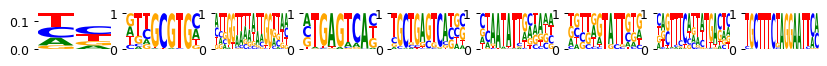

verbose=2
current kernel 0

### next filter to optimize 0 (intercept)

FREEZING KERNELS
optimizing feature type mono
next kernels {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Current time: 2024-05-23 17:58:20.075154
	Loss: 267.160 , R2: 0.357
	Training time (model/function): (5.352s / 5.352s)
		per epoch (model/function): (0.382s/ 0.382s)
		per 1k samples: 1.341s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimization of dinuc is not valid for the intercept (filter=0). Skip...
current kernel 10

### next filter to optimize 10 

FREEZING KERNELS
optimizing feature type mono
next kernels {10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.14it/s]


Current time: 2024-05-23 17:58:27.586350
	Loss: 258.591 , R2: 0.368
	Training time (model/function): (12.364s / 7.012s)
		per epoch (model/function): (0.883s/ 0.501s)
		per 1k samples: 1.757s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.41it/s]


Current time: 2024-05-23 17:58:34.381094
	Loss: 245.508 , R2: 0.368
	Training time (model/function): (18.591s / 6.227s)
		per epoch (model/function): (1.328s/ 0.445s)
		per 1k samples: 1.561s
best loss 245.508
last five r2 values, by sequential filter optimization: ['0.371']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 20

### next filter to optimize 20 

FREEZING KERNELS
optimizing feature type mono
next kernels {20, 21, 22, 23, 24, 25, 26, 27, 28, 29}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.81it/s]


Current time: 2024-05-23 17:58:43.781113
	Loss: 239.680 , R2: 0.379
	Training time (model/function): (26.895s / 8.304s)
		per epoch (model/function): (1.921s/ 0.593s)
		per 1k samples: 2.081s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.39it/s]


Current time: 2024-05-23 17:58:55.187165
	Loss: 226.356 , R2: 0.379
	Training time (model/function): (37.657s / 10.762s)
		per epoch (model/function): (2.690s/ 0.769s)
		per 1k samples: 2.697s
best loss 226.356
last five r2 values, by sequential filter optimization: ['0.371', '0.381']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 30

### next filter to optimize 30 

FREEZING KERNELS
optimizing feature type mono
next kernels {32, 33, 34, 35, 36, 37, 38, 39, 30, 31}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.82it/s]


Current time: 2024-05-23 17:59:04.445144
	Loss: 220.975 , R2: 0.384
	Training time (model/function): (45.921s / 8.264s)
		per epoch (model/function): (3.280s/ 0.590s)
		per 1k samples: 2.071s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.59it/s]


Current time: 2024-05-23 17:59:14.664450
	Loss: 208.613 , R2: 0.390
	Training time (model/function): (55.380s / 9.459s)
		per epoch (model/function): (3.956s/ 0.676s)
		per 1k samples: 2.371s
best loss 208.613
last five r2 values, by sequential filter optimization: ['0.371', '0.381', '0.386']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 40

### next filter to optimize 40 

FREEZING KERNELS
optimizing feature type mono
next kernels {40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.80it/s]


Current time: 2024-05-23 17:59:24.056709
	Loss: 204.522 , R2: 0.397
	Training time (model/function): (63.709s / 8.329s)
		per epoch (model/function): (4.551s/ 0.595s)
		per 1k samples: 2.088s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:20<00:00,  1.38s/it]


Current time: 2024-05-23 17:59:45.430515
	Loss: 193.627 , R2: 0.393
	Training time (model/function): (84.451s / 20.742s)
		per epoch (model/function): (6.032s/ 1.482s)
		per 1k samples: 5.199s
best loss 193.627
last five r2 values, by sequential filter optimization: ['0.371', '0.381', '0.386', '0.394']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 50

### next filter to optimize 50 

FREEZING KERNELS
optimizing feature type mono
next kernels {50, 51, 52, 53, 54, 55, 56, 57, 58, 59}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.50it/s]


Current time: 2024-05-23 17:59:56.541228
	Loss: 191.055 , R2: 0.407
	Training time (model/function): (94.461s / 10.009s)
		per epoch (model/function): (6.747s/ 0.715s)
		per 1k samples: 2.509s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.80it/s]


Current time: 2024-05-23 18:00:05.435922
	Loss: 181.651 , R2: 0.407
	Training time (model/function): (102.810s / 8.349s)
		per epoch (model/function): (7.344s/ 0.596s)
		per 1k samples: 2.093s
best loss 181.651
last five r2 values, by sequential filter optimization: ['0.371', '0.381', '0.386', '0.394', '0.399']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 60

### next filter to optimize 60 

FREEZING KERNELS
optimizing feature type mono
next kernels {64, 65, 66, 67, 68, 69, 60, 61, 62, 63}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.39it/s]


Current time: 2024-05-23 18:00:17.411599
	Loss: 180.487 , R2: 0.418
	Training time (model/function): (113.602s / 10.792s)
		per epoch (model/function): (8.114s/ 0.771s)
		per 1k samples: 2.705s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  1.97it/s]


Current time: 2024-05-23 18:00:25.988250
	Loss: 172.385 , R2: 0.409
	Training time (model/function): (121.206s / 7.604s)
		per epoch (model/function): (8.658s/ 0.543s)
		per 1k samples: 1.906s
best loss 172.385
last five r2 values, by sequential filter optimization: ['0.381', '0.386', '0.394', '0.399', '0.419']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 70

### next filter to optimize 70 

FREEZING KERNELS
optimizing feature type mono
next kernels {70, 71, 72, 73, 74, 75, 76, 77, 78, 79}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.80it/s]


Current time: 2024-05-23 18:00:35.332521
	Loss: 172.399 , R2: 0.409
	Training time (model/function): (129.561s / 8.354s)
		per epoch (model/function): (9.254s/ 0.597s)
		per 1k samples: 2.094s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.63it/s]


Current time: 2024-05-23 18:00:45.485470
	Loss: 165.346 , R2: 0.417
	Training time (model/function): (138.756s / 9.196s)
		per epoch (model/function): (9.911s/ 0.657s)
		per 1k samples: 2.305s
best loss 165.346
last five r2 values, by sequential filter optimization: ['0.386', '0.394', '0.399', '0.419', '0.423']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 80

### next filter to optimize 80 

FREEZING KERNELS
optimizing feature type mono
next kernels {80, 81, 82, 83, 84, 85, 86, 87, 88, 89}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.14it/s]


Current time: 2024-05-23 18:00:53.497990
	Loss: 166.289 , R2: 0.422
	Training time (model/function): (145.779s / 7.023s)
		per epoch (model/function): (10.413s/ 0.502s)
		per 1k samples: 1.760s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.48it/s]


Current time: 2024-05-23 18:01:04.321279
	Loss: 160.052 , R2: 0.417
	Training time (model/function): (155.930s / 10.151s)
		per epoch (model/function): (11.138s/ 0.725s)
		per 1k samples: 2.544s
best loss 160.052
last five r2 values, by sequential filter optimization: ['0.394', '0.399', '0.419', '0.423', '0.431']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 90

### next filter to optimize 90 

FREEZING KERNELS
optimizing feature type mono
next kernels {96, 97, 98, 99, 90, 91, 92, 93, 94, 95}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.03it/s]


Current time: 2024-05-23 18:01:12.505727
	Loss: 161.708 , R2: 0.427
	Training time (model/function): (163.328s / 7.398s)
		per epoch (model/function): (11.666s/ 0.528s)
		per 1k samples: 1.854s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.56it/s]


Current time: 2024-05-23 18:01:22.805467
	Loss: 156.095 , R2: 0.412
	Training time (model/function): (172.948s / 9.620s)
		per epoch (model/function): (12.353s/ 0.687s)
		per 1k samples: 2.411s
best loss 156.095
last five r2 values, by sequential filter optimization: ['0.399', '0.419', '0.423', '0.431', '0.413']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 100

### next filter to optimize 100 

FREEZING KERNELS
optimizing feature type mono
next kernels {100, 101, 102, 103, 104, 105, 106, 107, 108, 109}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.71it/s]


Current time: 2024-05-23 18:01:32.587396
	Loss: 158.289 , R2: 0.446
	Training time (model/function): (181.741s / 8.793s)
		per epoch (model/function): (12.982s/ 0.628s)
		per 1k samples: 2.204s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:14<00:00,  1.06it/s]


Current time: 2024-05-23 18:01:47.383446
	Loss: 153.145 , R2: 0.426
	Training time (model/function): (195.899s / 14.158s)
		per epoch (model/function): (13.993s/ 1.011s)
		per 1k samples: 3.548s
best loss 153.145
last five r2 values, by sequential filter optimization: ['0.419', '0.423', '0.431', '0.413', '0.424']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 110

### next filter to optimize 110 

FREEZING KERNELS
optimizing feature type mono
next kernels {110, 111, 112, 113, 114, 115, 116, 117, 118, 119}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.36it/s]


Current time: 2024-05-23 18:01:59.742287
	Loss: 155.743 , R2: 0.430
	Training time (model/function): (206.931s / 11.032s)
		per epoch (model/function): (14.781s/ 0.788s)
		per 1k samples: 2.765s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.46it/s]


Current time: 2024-05-23 18:02:10.704238
	Loss: 150.950 , R2: 0.435
	Training time (model/function): (217.245s / 10.315s)
		per epoch (model/function): (15.518s/ 0.737s)
		per 1k samples: 2.585s
best loss 150.950
last five r2 values, by sequential filter optimization: ['0.423', '0.431', '0.413', '0.424', '0.413']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 120

### next filter to optimize 120 

FREEZING KERNELS
optimizing feature type mono
next kernels {128, 129, 120, 121, 122, 123, 124, 125, 126, 127}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.41it/s]


Current time: 2024-05-23 18:02:22.656462
	Loss: 153.848 , R2: 0.432
	Training time (model/function): (227.861s / 10.616s)
		per epoch (model/function): (16.276s/ 0.758s)
		per 1k samples: 2.661s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.34it/s]


Current time: 2024-05-23 18:02:34.537823
	Loss: 149.319 , R2: 0.417
	Training time (model/function): (239.094s / 11.233s)
		per epoch (model/function): (17.078s/ 0.802s)
		per 1k samples: 2.815s
best loss 149.319
last five r2 values, by sequential filter optimization: ['0.431', '0.413', '0.424', '0.413', '0.444']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 130

### next filter to optimize 130 

FREEZING KERNELS
optimizing feature type mono
next kernels {130, 131, 132, 133, 134, 135, 136, 137, 138, 139}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.33it/s]


Current time: 2024-05-23 18:02:46.899799
	Loss: 152.442 , R2: 0.457
	Training time (model/function): (250.413s / 11.319s)
		per epoch (model/function): (17.887s/ 0.809s)
		per 1k samples: 2.837s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.49it/s]


Current time: 2024-05-23 18:02:57.576919
	Loss: 148.107 , R2: 0.430
	Training time (model/function): (260.496s / 10.083s)
		per epoch (model/function): (18.607s/ 0.720s)
		per 1k samples: 2.527s
best loss 148.107
last five r2 values, by sequential filter optimization: ['0.413', '0.424', '0.413', '0.444', '0.440']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 140

### next filter to optimize 140 

FREEZING KERNELS
optimizing feature type mono
next kernels {140, 141, 142, 143, 144, 145, 146, 147, 148, 149}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.32it/s]


Current time: 2024-05-23 18:03:10.175466
	Loss: 151.394 , R2: 0.459
	Training time (model/function): (271.886s / 11.390s)
		per epoch (model/function): (19.420s/ 0.814s)
		per 1k samples: 2.855s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.34it/s]


Current time: 2024-05-23 18:03:21.795666
	Loss: 147.206 , R2: 0.446
	Training time (model/function): (283.047s / 11.161s)
		per epoch (model/function): (20.218s/ 0.797s)
		per 1k samples: 2.797s
best loss 147.206
last five r2 values, by sequential filter optimization: ['0.424', '0.413', '0.444', '0.440', '0.437']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 150

### next filter to optimize 150 

FREEZING KERNELS
optimizing feature type mono
next kernels {150, 151, 152, 153, 154, 155, 156, 157, 158, 159}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.64it/s]


Current time: 2024-05-23 18:03:32.419376
	Loss: 150.616 , R2: 0.433
	Training time (model/function): (292.204s / 9.157s)
		per epoch (model/function): (20.872s/ 0.654s)
		per 1k samples: 2.295s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.33it/s]


Current time: 2024-05-23 18:03:44.282169
	Loss: 146.538 , R2: 0.434
	Training time (model/function): (303.463s / 11.259s)
		per epoch (model/function): (21.676s/ 0.804s)
		per 1k samples: 2.822s
best loss 146.538
last five r2 values, by sequential filter optimization: ['0.413', '0.444', '0.440', '0.437', '0.434']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 160

### next filter to optimize 160 

FREEZING KERNELS
optimizing feature type mono
next kernels {160, 161, 162, 163, 164, 165, 166, 167, 168, 169}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.70it/s]


Current time: 2024-05-23 18:03:54.057543
	Loss: 150.039 , R2: 0.430
	Training time (model/function): (312.311s / 8.848s)
		per epoch (model/function): (22.308s/ 0.632s)
		per 1k samples: 2.218s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.32it/s]


Current time: 2024-05-23 18:04:06.068405
	Loss: 146.042 , R2: 0.444
	Training time (model/function): (323.662s / 11.351s)
		per epoch (model/function): (23.119s/ 0.811s)
		per 1k samples: 2.845s
best loss 146.042
last five r2 values, by sequential filter optimization: ['0.444', '0.440', '0.437', '0.434', '0.438']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 170

### next filter to optimize 170 

FREEZING KERNELS
optimizing feature type mono
next kernels {170, 171, 172, 173, 174, 175, 176, 177, 178, 179}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.73it/s]


Current time: 2024-05-23 18:04:15.889344
	Loss: 149.611 , R2: 0.453
	Training time (model/function): (332.357s / 8.695s)
		per epoch (model/function): (23.740s/ 0.621s)
		per 1k samples: 2.179s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.48it/s]


Current time: 2024-05-23 18:04:27.046805
	Loss: 145.673 , R2: 0.469
	Training time (model/function): (342.473s / 10.116s)
		per epoch (model/function): (24.462s/ 0.723s)
		per 1k samples: 2.535s
best loss 145.673
last five r2 values, by sequential filter optimization: ['0.440', '0.437', '0.434', '0.438', '0.458']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 180

### next filter to optimize 180 

FREEZING KERNELS
optimizing feature type mono
next kernels {180, 181, 182, 183, 184, 185, 186, 187, 188, 189}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.42it/s]


Current time: 2024-05-23 18:04:38.724950
	Loss: 149.292 , R2: 0.490
	Training time (model/function): (353.058s / 10.585s)
		per epoch (model/function): (25.218s/ 0.756s)
		per 1k samples: 2.653s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.30it/s]


Current time: 2024-05-23 18:04:51.035377
	Loss: 145.400 , R2: 0.429
	Training time (model/function): (364.623s / 11.565s)
		per epoch (model/function): (26.045s/ 0.826s)
		per 1k samples: 2.899s
best loss 145.400
last five r2 values, by sequential filter optimization: ['0.437', '0.434', '0.438', '0.458', '0.471']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 190

### next filter to optimize 190 

FREEZING KERNELS
optimizing feature type mono
next kernels {192, 193, 194, 195, 196, 197, 198, 199, 190, 191}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.42it/s]


Current time: 2024-05-23 18:05:02.770015
	Loss: 149.055 , R2: 0.449
	Training time (model/function): (375.231s / 10.607s)
		per epoch (model/function): (26.802s/ 0.758s)
		per 1k samples: 2.658s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.55it/s]


Current time: 2024-05-23 18:05:13.076977
	Loss: 145.197 , R2: 0.489
	Training time (model/function): (384.900s / 9.669s)
		per epoch (model/function): (27.493s/ 0.691s)
		per 1k samples: 2.423s
best loss 145.197
last five r2 values, by sequential filter optimization: ['0.434', '0.438', '0.458', '0.471', '0.449']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 200

### next filter to optimize 200 

FREEZING KERNELS
optimizing feature type mono
next kernels {200, 201, 202, 203, 204, 205, 206, 207, 208, 209}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.45it/s]


Current time: 2024-05-23 18:05:24.429551
	Loss: 148.879 , R2: 0.457
	Training time (model/function): (395.243s / 10.343s)
		per epoch (model/function): (28.232s/ 0.739s)
		per 1k samples: 2.592s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:19<00:00,  1.30s/it]


Current time: 2024-05-23 18:05:44.543649
	Loss: 145.045 , R2: 0.444
	Training time (model/function): (414.693s / 19.451s)
		per epoch (model/function): (29.621s/ 1.389s)
		per 1k samples: 4.875s
best loss 145.045
last five r2 values, by sequential filter optimization: ['0.438', '0.458', '0.471', '0.449', '0.454']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 210

### next filter to optimize 210 

FREEZING KERNELS
optimizing feature type mono
next kernels {210, 211, 212, 213, 214, 215, 216, 217, 218, 219}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.84it/s]


Current time: 2024-05-23 18:05:53.884669
	Loss: 148.749 , R2: 0.504
	Training time (model/function): (422.844s / 8.151s)
		per epoch (model/function): (30.203s/ 0.582s)
		per 1k samples: 2.043s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.75it/s]


Current time: 2024-05-23 18:06:02.894068
	Loss: 144.933 , R2: 0.453
	Training time (model/function): (431.415s / 8.571s)
		per epoch (model/function): (30.815s/ 0.612s)
		per 1k samples: 2.148s
best loss 144.933
last five r2 values, by sequential filter optimization: ['0.458', '0.471', '0.449', '0.454', '0.452']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 220

### next filter to optimize 220 

FREEZING KERNELS
optimizing feature type mono
next kernels {224, 225, 226, 227, 228, 229, 220, 221, 222, 223}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.16it/s]


Current time: 2024-05-23 18:06:11.184229
	Loss: 148.653 , R2: 0.478
	Training time (model/function): (438.375s / 6.959s)
		per epoch (model/function): (31.312s/ 0.497s)
		per 1k samples: 1.744s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.51it/s]


Current time: 2024-05-23 18:06:21.685242
	Loss: 144.851 , R2: 0.479
	Training time (model/function): (448.302s / 9.927s)
		per epoch (model/function): (32.022s/ 0.709s)
		per 1k samples: 2.488s
best loss 144.851
last five r2 values, by sequential filter optimization: ['0.471', '0.449', '0.454', '0.452', '0.466']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 230

### next filter to optimize 230 

FREEZING KERNELS
optimizing feature type mono
next kernels {230, 231, 232, 233, 234, 235, 236, 237, 238, 239}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.59it/s]


Current time: 2024-05-23 18:06:32.281018
	Loss: 148.580 , R2: 0.456
	Training time (model/function): (457.749s / 9.447s)
		per epoch (model/function): (32.696s/ 0.675s)
		per 1k samples: 2.368s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.65it/s]


Current time: 2024-05-23 18:06:41.934655
	Loss: 144.788 , R2: 0.469
	Training time (model/function): (466.872s / 9.124s)
		per epoch (model/function): (33.348s/ 0.652s)
		per 1k samples: 2.287s
best loss 144.788
last five r2 values, by sequential filter optimization: ['0.449', '0.454', '0.452', '0.466', '0.461']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 240

### next filter to optimize 240 

FREEZING KERNELS
optimizing feature type mono
next kernels {240, 241, 242, 243, 244, 245, 246, 247, 248, 249}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.61it/s]


Current time: 2024-05-23 18:06:52.182762
	Loss: 148.530 , R2: 0.448
	Training time (model/function): (476.196s / 9.324s)
		per epoch (model/function): (34.014s/ 0.666s)
		per 1k samples: 2.337s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.39it/s]


Current time: 2024-05-23 18:07:03.674070
	Loss: 144.742 , R2: 0.421
	Training time (model/function): (487.011s / 10.815s)
		per epoch (model/function): (34.786s/ 0.773s)
		per 1k samples: 2.711s
best loss 144.742
last five r2 values, by sequential filter optimization: ['0.454', '0.452', '0.466', '0.461', '0.454']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 250

### next filter to optimize 250 

FREEZING KERNELS
optimizing feature type mono
next kernels {256, 257, 258, 259, 250, 251, 252, 253, 254, 255}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.66it/s]


Current time: 2024-05-23 18:07:13.744177
	Loss: 148.489 , R2: 0.478
	Training time (model/function): (496.030s / 9.019s)
		per epoch (model/function): (35.431s/ 0.644s)
		per 1k samples: 2.260s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.42it/s]


Current time: 2024-05-23 18:07:24.891523
	Loss: 144.708 , R2: 0.455
	Training time (model/function): (506.562s / 10.532s)
		per epoch (model/function): (36.183s/ 0.752s)
		per 1k samples: 2.640s
best loss 144.708
last five r2 values, by sequential filter optimization: ['0.452', '0.466', '0.461', '0.454', '0.464']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 260

### next filter to optimize 260 

FREEZING KERNELS
optimizing feature type mono
next kernels {260, 261, 262, 263, 264, 265, 266, 267, 268, 269}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.44it/s]


Current time: 2024-05-23 18:07:36.589927
	Loss: 148.459 , R2: 0.483
	Training time (model/function): (516.989s / 10.427s)
		per epoch (model/function): (36.928s/ 0.745s)
		per 1k samples: 2.613s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:22<00:00,  1.47s/it]


Current time: 2024-05-23 18:07:59.555576
	Loss: 144.683 , R2: 0.464
	Training time (model/function): (539.115s / 22.126s)
		per epoch (model/function): (38.508s/ 1.580s)
		per 1k samples: 5.545s
best loss 144.683
last five r2 values, by sequential filter optimization: ['0.466', '0.461', '0.454', '0.464', '0.498']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 270

### next filter to optimize 270 

FREEZING KERNELS
optimizing feature type mono
next kernels {270, 271, 272, 273, 274, 275, 276, 277, 278, 279}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.46it/s]


Current time: 2024-05-23 18:08:11.780610
	Loss: 148.437 , R2: 0.491
	Training time (model/function): (549.398s / 10.283s)
		per epoch (model/function): (39.243s/ 0.735s)
		per 1k samples: 2.577s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.46it/s]


Current time: 2024-05-23 18:08:22.726162
	Loss: 144.664 , R2: 0.435
	Training time (model/function): (559.679s / 10.281s)
		per epoch (model/function): (39.977s/ 0.734s)
		per 1k samples: 2.577s
best loss 144.664
last five r2 values, by sequential filter optimization: ['0.461', '0.454', '0.464', '0.498', '0.462']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...
current kernel 280

### next filter to optimize 280 

FREEZING KERNELS
optimizing feature type mono
next kernels {288, 289, 280, 281, 282, 283, 284, 285, 286, 287}
filters mask None
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.42it/s]


Current time: 2024-05-23 18:08:34.425990
	Loss: 148.420 , R2: 0.507
	Training time (model/function): (570.274s / 10.595s)
		per epoch (model/function): (40.734s/ 0.757s)
		per 1k samples: 2.655s
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))


final refinement step (after shift)...unfreezing all layers
optimizer:  Adam , criterion: PoissonLoss 
epochs: 15 
early_stopping: 250
lr= 0.01, weight_decay= 0, dir weight= 0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  1.89it/s]


Current time: 2024-05-23 18:08:42.878838
	Loss: 144.649 , R2: 0.496
	Training time (model/function): (578.204s / 7.930s)
		per epoch (model/function): (41.300s/ 0.566s)
		per 1k samples: 1.988s
best loss 144.649
last five r2 values, by sequential filter optimization: ['0.454', '0.464', '0.498', '0.462', '0.444']
('etas corr with lib_sizes (before refinement)', SignificanceResult(statistic=0.9995094658585428, pvalue=9.194108130059318e-288))
optimizing feature type dinuc
the optimization of dinucleotide features is skipped...

optimization finished:
total time: 578.2042829990387s
Time per epoch (total): 0.134 s


In [53]:
import torch.optim as topti
import warnings

model_by_logdynamic = {}
n_epochs_intercept = 15
n_epochs_kernel = 15
log_each=75

for optimize_log_dynamic in [True, False]:
    warnings.filterwarnings("ignore")

    criterion = mb.tl.PoissonLoss()
    w = [r.shape[1] for r in pwms]
    model = mb.models.Mubind.make_model(train, n_kernels, criterion, kernels=[0, 2,] + w, # [0, 2] + w,
                                           # use_dinuc=True, dinuc_mode='full',
                                           optimize_sym_weight=False,
                                           optimize_exp_barrier=True,
                                           optimize_prob_act=True,
                                           optimize_log_dynamic=optimize_log_dynamic,
                                           use_dinuc=False,
                                           device=device,
                                           p_dropout=0.8,
                                           prepare_knn=optimize_log_dynamic,
                                           knn_free_weights=False,
                                           adata=None if not optimize_log_dynamic else ad,
                                           dinuc_mode=None) # .cuda()

    # initialize the reduce kernels
    for i, mono_best in enumerate(pwms):
        mono_best = mono_best.to_numpy()
        if mono_best.shape[-1] == 0:
            continue
        # print(mono_best.shape, model.binding_modes.conv_mono[i + 1].weight.shape)
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
        new_w = mono_best.reshape([1, 1] + list(mono_best.shape))
        # print(i, i + 1)
        model.binding_modes.conv_mono[i + 2].weight = torch.nn.Parameter(torch.tensor(new_w, dtype=torch.float))
        # print(model.binding_modes.conv_mono[i + 1].weight.device)
    # move the model a final time to the GPU
    model = model.to(device)

    mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
    mb.pl.logo(model,
               title=False,
               xticks=False,
               rowspan_dinuc=0,
               rowspan_mono=1,
               n_rows=5,
               n_cols=12,
               stop_at=10   ) # n_cols=len(reduced_groups))

    mb.pl.set_rcParams({'figure.figsize': [20, 5], 'figure.dpi': 100})

    # mb.pl.conv(model, n_cols=2)
    import torch.nn as tnn

    model, best_loss = model.optimize_iterative(train,
                                                n_epochs=[n_epochs_intercept] + [n_epochs_kernel] * (n_kernels + 1),
                                                show_logo=False,
                                                use_mono=True, use_dinuc=False, dinuc_mode='local',
                                                opt_kernel_shift=[0, 0] + [0] * (n_kernels),
                                                opt_kernel_length=[0, 0] + [0] * (n_kernels),
                                                opt_one_step=True,
                                                shift_max=1, shift_step=1,
                                                # optimiser=topti.SGD,
                                                optimiser=topti.Adam,
                                                n_unfreeze_kernels=10,
                                                # skip_kernels=list(range(1, 2)) + list(range(5, 500)),
                                                n_batches=1, n_rounds=2, num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                                kernels = [0] + [2] + [20] * (n_kernels), r2_per_epoch=True,
                                                exp_max=8,
                                                early_stopping=250, log_each=log_each, w=20, max_w=20) #  target_dim=train.dataset.signal.shape[1])

    model_by_logdynamic[optimize_log_dynamic] = model

In [54]:
print('here...')

here...


Text(0.5, 0, 'learned etas (per sample)')

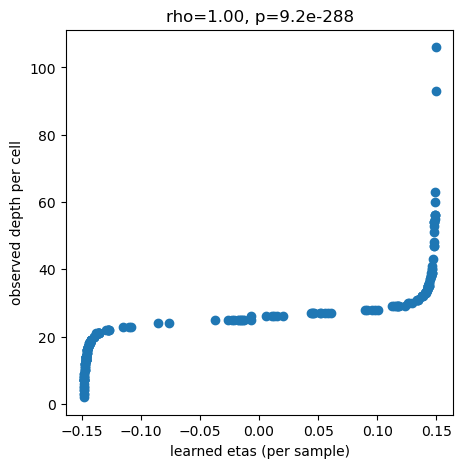

In [55]:
## correlation between etas and observed counts per cell
rcParams['figure.figsize'] = 5, 5
etas = model.get_log_etas()
lib_sizes = train.dataset.rounds.sum(axis=0)
etas.shape, lib_sizes.shape
from scipy.stats import spearmanr

a = etas.detach().cpu().flatten()
b = lib_sizes.flatten()
plt.scatter(a, b)
plt.title('rho=%.2f, p=%.2g' % spearmanr(a, b))
plt.ylabel('observed depth per cell')
plt.xlabel('learned etas (per sample)')

In [56]:
save_output = False

if save_output:
    for use_logdynamic in [False, True]:
        p = 'pancreas_multiome_use_logdynamic_%i.pth' % use_logdynamic
        print(p)
        torch.save(model_by_logdynamic[use_logdynamic], p)

    ad.write('atac_train.h5ad')
    rna_sample.write('rna_sample_train.h5ad')

    import pickle
    pickle.dump(train, open('train_dataloader.pkl', 'wb'))